In [1]:
import warnings
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
from xlmr_culture_classification import XLMRCultureClassifier, XLMRCultureClassifier_2
from datasets import Dataset
from transformers import AdamW, XLMRobertaTokenizerFast, XLMRobertaForTokenClassification, DataCollatorForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from seqeval.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

c:\coding\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

##### General set up

In [3]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

In [4]:
cultural_train = "data/train_merged_output_cultural.conll"
# cultural_train = "annotation/test/fully_annotated_span_test_lyrics.conll"
cultural_test = "data/test_merged_output.conll"
# cultural_test = "annotation/train/fully_annotated_lyrics_span.conll"

In [5]:
def extract_refs(json_path):
    cultural_refs_tag = []
    cultural_refs_IDs = {}

    with open(json_path, "r") as f:
        cultural_data = json.load(f)
        cultural_refs_tag.extend([entry['tag'] for entry in cultural_data])
        cultural_refs_IDs.update({entry['tag']: entry['id'] for entry in cultural_data})

    return cultural_refs_tag, cultural_refs_IDs

ner_tags_path = "data/ner_tags.json"
cultural_ref_tags_path = "data/cultural_tags.json"

ner_tags, tag2id_ner = extract_refs(ner_tags_path)
cultural_tags, tag2id_cultural = extract_refs(cultural_ref_tags_path)

num_labels_culture = len(tag2id_cultural)
num_labels_ner = len(tag2id_ner)

id2tag_ner = {v: k for k, v in tag2id_ner.items()}
id2tag_cultural = {v: k for k, v in tag2id_cultural.items()}

In [6]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")    
#     print('There are %d GPU(s) available.' % torch.cuda.device_count())
#     print('GPU is:', torch.cuda.get_device_name(0))
# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

##### Vizualizations

In [7]:
header = {0:'token', 1:'ner_tag', 2:'cultural_tag'}

chunksize = 100000
chunks = []  # List to store chunks

In [8]:
chunks = pd.read_csv(cultural_train, encoding='utf-8', sep='\t', engine='python', on_bad_lines='skip', header=None, low_memory=True,chunksize=chunksize)

In [9]:
chunks = pd.read_csv(
    cultural_train,
    encoding='utf-8',
    sep='\t',
    engine='python',
    on_bad_lines='skip',
    header=None,
    quoting=csv.QUOTE_NONE,
    chunksize=100000,
    low_memory=True
)


In [10]:
df = pd.concat(chunks, ignore_index=True)

In [11]:
df.rename(columns=header)

,token,ner_tag,cultural_tag
0,1-6,O,-
1,-,O,-
2,6,O,-
3,Santan,B-PER,European
4,from,O,-
...,...,...,...
47095,subir,O,-
47096,y,O,-
47097,bajar,O,-
47098,",",O,-


In [12]:
exclude = ['-']
filtered_cult = df[~df[2].isin(exclude)]

In [13]:
filtered_cult

,0,1,2
3,Santan,B-PER,European
6,V-V,B-LOC,European
8,AJ,B-PER,European
15,J,B-PER,European
16,.,I-PER,European
...,...,...,...
47044,mancha,I-LOC,European
47047,Raval,B-LOC,European
47049,merca,B-MISC,European
47052,Besós,B-LOC,European


<AxesSubplot: xlabel='2'>

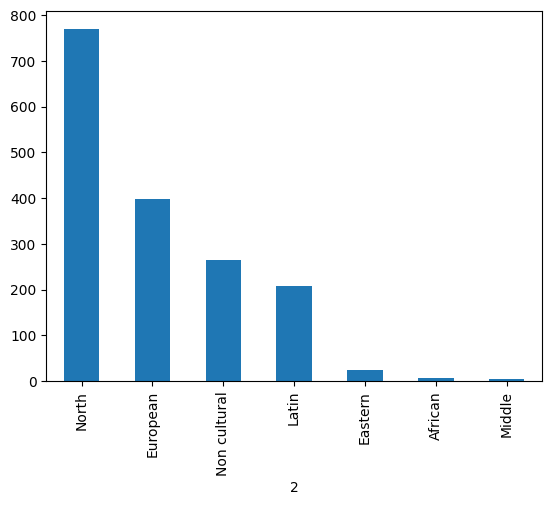

In [14]:
filtered_cult[2].value_counts().plot.bar()
#imbalanced data for training


In [15]:
exclude = ['O']
filtered_ner = df[~df[1].isin(exclude)]

<AxesSubplot: xlabel='1'>

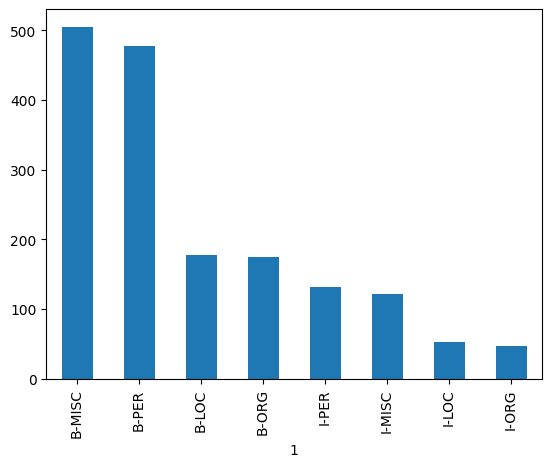

In [16]:
filtered_ner[1].value_counts().plot.bar()

#### Data aligment

In [17]:
def parse_conllu(file_path):
    " This function create a usable dataset of the sparse .conllu file with the NER tags and cultural refferences"
    sentences = []
    tags = []
    cultural_references = []
    
    with open(file_path, "r",encoding="utf-8") as file:
        tokens = []
        ner_tags = []
        cultural_ref = []
        
        for line in file:
            line = line.strip()
                       
            if not line:
                if tokens:  
                    sentences.append(tokens)
                    tags.append(ner_tags)
                    cultural_references.append(cultural_ref)
              
                tokens = []
                ner_tags = []
                cultural_ref = []
                continue

            parts = line.split("\t")
            
            if len(parts) >= 3:
                token = parts[0]  
                ner_tag = parts[1] 
                cultural_ref_val = parts[2]
                
                tokens.append(token)
                ner_tags.append(ner_tag)
                cultural_ref.append(cultural_ref_val)
        
       
        if tokens:
            sentences.append(tokens)
            tags.append(ner_tags)
            cultural_references.append(cultural_ref)
    
    return sentences, tags, cultural_references

In [18]:
sentences, tags, cultural_refs = parse_conllu(cultural_train)
train_data = [{"tokens": s, "ner_tags": t, "cultural_ref": c} for s, t, c in zip(sentences, tags, cultural_refs)]
dataset_train = Dataset.from_list(train_data)

In [19]:
#load test data for later use:
sentences_test, tags_test, cultural_refs_test = parse_conllu(cultural_test)
test_data = [{"tokens": s, "ner_tags": t, "cultural_ref": c} for s, t, c in zip(sentences_test, tags_test, cultural_refs_test)]
dataset_test = Dataset.from_list(test_data)

In [20]:
dataset = dataset_train.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

In [21]:
train_dataset

Dataset({
    features: ['tokens', 'ner_tags', 'cultural_ref'],
    num_rows: 4803
})

In [22]:
def tokenize_and_align_labels_with_cultural(example):
    tokenized = tokenizer(
        example['tokens'], 
        truncation=True, 
        padding=True,
        is_split_into_words=True
    )

    labels = []
    cultural_ref = []

    for i, word in enumerate(example['tokens']):
        if example['ner_tags'][i] != "O":
            
            labels.append(tag2id_ner.get(example['ner_tags'][i], -100))
            
            cultural_ref.append(tag2id_cultural.get(example['cultural_ref'][i], -100))
        else:
            labels.append(-100)
            cultural_ref.append(-100)

    tokenized['labels'] = labels
    tokenized['cultural_ref'] = cultural_ref
    return tokenized


In [23]:
tokenized_cultural_train = train_dataset.map(tokenize_and_align_labels_with_cultural)
tokenized_cultural_val = val_dataset.map(tokenize_and_align_labels_with_cultural)


Map:   0%|          | 0/4803 [00:00<?, ? examples/s]

In [24]:
tokenized_cultural_test = dataset_test.map(tokenize_and_align_labels_with_cultural)

Map:   0%|          | 0/2952 [00:00<?, ? examples/s]

In [25]:
print(tokenized_cultural_train[7]['input_ids'])
print(tokenized_cultural_train[7]['labels'])


[0, 84415, 41537, 26, 7, 40960, 152, 45327, 6, 4, 23040, 6, 4, 87, 3444, 935, 14361, 6, 4, 87, 3444, 935, 14361, 6, 4, 242, 22304, 111, 450, 6957, 4998, 26, 19780, 20751, 6, 5, 45327, 6, 4, 23040, 6, 4, 87, 3444, 935, 14361, 6, 4, 87, 3444, 935, 14361, 6, 4, 242, 22304, 111, 450, 6957, 4998, 26, 19780, 20751, 2]
[3, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [26]:
# tokenized_cultural_train[7]

In [27]:
for i in range(3):
    tokens = tokenizer.convert_ids_to_tokens(tokenized_cultural_train[i]['input_ids'])
    labels = [id2tag_cultural.get(id, "IGN") for id in tokenized_cultural_train[i]['labels']]
    print(list(zip(tokens, labels)))

[('<s>', 'IGN'), ('▁When', 'IGN'), ('▁I', 'IGN'), ('▁want', 'IGN'), ('▁you', 'IGN'), ('▁in', 'IGN'), ('▁my', 'IGN')]
[('<s>', 'IGN'), ('▁I', 'IGN'), ('▁got', 'IGN'), ('▁the', 'IGN'), ('▁love', 'IGN'), ('▁bir', 'IGN'), ('ds', 'IGN'), ('▁chi', 'IGN'), ('r', 'IGN')]
[('<s>', 'IGN'), ('▁Cuando', 'IGN'), ('▁te', 'IGN'), ('▁lo', 'IGN'), ('▁qui', 'IGN'), ('to', 'IGN'), ('▁des', 'IGN'), ('pu', 'IGN')]


#### Model set up

In [28]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [29]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2tag_cultural[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag_cultural[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

##### Model version 1

In [30]:
#addign class weights
all_labels = [
    label for seq in tokenized_cultural_train['labels']
    for label in seq if label != -100]

train_labels_present = np.unique(all_labels)

class_weights_raw = compute_class_weight(class_weight="balanced", classes=train_labels_present, y=all_labels)

full_class_weights = torch.ones(len(id2tag_cultural), dtype=torch.float)

# Add all class weights, as some of them are not present in the training set
for i, label in enumerate(train_labels_present):
    full_class_weights[label] = class_weights_raw[i]


##### Model 1.

In [31]:
# culture_model = XLMRCultureClassifier(num_labels_culture,class_weights=full_class_weights)
# optimizer = AdamW(culture_model.parameters(), lr=5e-5)

In [32]:
# #cult model 1
# training_args = TrainingArguments(
#     output_dir="./xlmr-cultural-model",
#     save_strategy="steps",
#     save_steps=50,
#     evaluation_strategy="steps",
#     eval_steps=25,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     greater_is_better=False,
#     logging_dir="./logs",
#     logging_steps=10,
#     learning_rate=3e-5,
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     max_grad_norm=1.0,
#     save_total_limit=2,
#     remove_unused_columns=True,
#     fp16=False,
# )

# trainer = Trainer(
#     model=culture_model,
#     args=training_args,
#     train_dataset=tokenized_cultural_train,
#     eval_dataset=tokenized_cultural_val,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     data_collator=data_collator,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
# )


##### Model version 2

In [33]:
# culture_model_2 = XLMRCultureClassifier_2(num_labels_culture,class_weights=full_class_weights)
# optimizer = AdamW(culture_model_2.parameters(), lr=5e-5)

In [34]:
# #Alternative classifier
# training_args_2 = TrainingArguments(
#     output_dir="./xlmr-cultural-model_2",
#     save_strategy="steps",
#     save_steps=50,
#     evaluation_strategy="steps",
#     eval_steps=25,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     greater_is_better=False,
#     logging_dir="./logs",
#     logging_steps=10,
#     learning_rate=3e-5,
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     max_grad_norm=1.0,
#     save_total_limit=2,
#     remove_unused_columns=True,
#     fp16=False,
# )

# trainer_2 = Trainer(
#     model=culture_model_2,
#     args=training_args_2,
#     train_dataset=tokenized_cultural_train,
#     eval_dataset=tokenized_cultural_val,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     data_collator=data_collator,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],)

##### Final model (ver3.)

In [35]:
model_funziez = XLMRobertaForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=num_labels_culture,
    id2label=id2tag_cultural,
    label2id=tag2id_cultural)

optimizer = AdamW(model_funziez.parameters(), lr=5e-5)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to us

In [36]:
training_args_fun = TrainingArguments(
    output_dir="./xlmr-cultural-funziez",
    save_strategy="steps",
    save_steps=100,
    evaluation_strategy="steps",
    eval_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=3e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    max_grad_norm=1.0,
    save_total_limit=2,
    remove_unused_columns=True,
    fp16=False,
)

trainer_fun = Trainer(
    model=model_funziez,
    args=training_args_fun,
    train_dataset=tokenized_cultural_train,
    eval_dataset=tokenized_cultural_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],)

##### Model training and evaluation

##### 1.

In [37]:
# trainer.train()

In [38]:
# # # model 1
# outputs = trainer.predict(tokenized_cultural_test)

# preds = np.argmax(outputs.predictions, axis=2)
# labels = outputs.label_ids

In [39]:
# eval_results = trainer.evaluate()

# print(eval_results)

In [40]:
# trainer.evaluate(tokenized_cultural_test)

##### 2.

In [41]:
# trainer_2.train()

In [42]:
# #model 2
# outputs_2 = trainer_2.predict(tokenized_cultural_test)

# preds_2 = np.argmax(outputs_2.predictions, axis=2)
# labels_2 = outputs_2.label_ids

In [43]:
# eval_results_2 = trainer_2.evaluate()

# print(eval_results_2)

In [44]:
# trainer_2.evaluate(tokenized_cultural_test)

##### 3.

In [45]:
trainer_fun.train()

  0%|          | 0/380 [00:00<?, ?it/s]You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                 
 13%|█▎        | 50/380 [06:32<52:05,  9.47s/it]

{'eval_loss': 1.870858073234558, 'eval_precision': 0.324468085106383, 'eval_recall': 0.324468085106383, 'eval_f1': 0.324468085106383, 'eval_runtime': 12.9829, 'eval_samples_per_second': 41.131, 'eval_steps_per_second': 0.693, 'epoch': 0.66}


 26%|██▋       | 100/380 [13:20<1:04:15, 13.77s/it]

{'loss': 1.8124, 'learning_rate': 2.2105263157894736e-05, 'epoch': 1.32}


                                                   
 26%|██▋       | 100/380 [13:33<1:04:15, 13.77s/it]

{'eval_loss': 1.5823993682861328, 'eval_precision': 0.3879781420765027, 'eval_recall': 0.3776595744680851, 'eval_f1': 0.3827493261455526, 'eval_runtime': 13.2138, 'eval_samples_per_second': 40.412, 'eval_steps_per_second': 0.681, 'epoch': 1.32}


                                                   
 39%|███▉      | 150/380 [20:10<30:44,  8.02s/it]

{'eval_loss': 1.3624930381774902, 'eval_precision': 0.5089820359281437, 'eval_recall': 0.4521276595744681, 'eval_f1': 0.47887323943661975, 'eval_runtime': 13.3088, 'eval_samples_per_second': 40.124, 'eval_steps_per_second': 0.676, 'epoch': 1.97}


 53%|█████▎    | 200/380 [26:38<26:17,  8.77s/it]

{'loss': 1.2372, 'learning_rate': 1.4210526315789473e-05, 'epoch': 2.63}


                                                 
 53%|█████▎    | 200/380 [26:52<26:17,  8.77s/it]

{'eval_loss': 1.2286182641983032, 'eval_precision': 0.5329341317365269, 'eval_recall': 0.4734042553191489, 'eval_f1': 0.5014084507042254, 'eval_runtime': 13.3192, 'eval_samples_per_second': 40.093, 'eval_steps_per_second': 0.676, 'epoch': 2.63}


                                                 
 66%|██████▌   | 250/380 [33:40<19:51,  9.16s/it]

{'eval_loss': 1.1771070957183838, 'eval_precision': 0.5952380952380952, 'eval_recall': 0.5319148936170213, 'eval_f1': 0.5617977528089887, 'eval_runtime': 13.2056, 'eval_samples_per_second': 40.437, 'eval_steps_per_second': 0.682, 'epoch': 3.29}


 79%|███████▉  | 300/380 [39:48<10:15,  7.70s/it]

{'loss': 0.908, 'learning_rate': 6.31578947368421e-06, 'epoch': 3.95}


                                                 
 79%|███████▉  | 300/380 [40:01<10:15,  7.70s/it]

{'eval_loss': 1.0896555185317993, 'eval_precision': 0.6568047337278107, 'eval_recall': 0.5904255319148937, 'eval_f1': 0.6218487394957983, 'eval_runtime': 13.3503, 'eval_samples_per_second': 39.999, 'eval_steps_per_second': 0.674, 'epoch': 3.95}


                                                 
 92%|█████████▏| 350/380 [46:51<03:51,  7.72s/it]

{'eval_loss': 1.0558536052703857, 'eval_precision': 0.6666666666666666, 'eval_recall': 0.5851063829787234, 'eval_f1': 0.623229461756374, 'eval_runtime': 13.8507, 'eval_samples_per_second': 38.554, 'eval_steps_per_second': 0.65, 'epoch': 4.61}


100%|██████████| 380/380 [50:21<00:00,  7.95s/it]

{'train_runtime': 3021.1845, 'train_samples_per_second': 7.949, 'train_steps_per_second': 0.126, 'train_loss': 1.196218450445878, 'epoch': 5.0}


TrainOutput(global_step=380, training_loss=1.196218450445878, metrics={'train_runtime': 3021.1845, 'train_samples_per_second': 7.949, 'train_steps_per_second': 0.126, 'train_loss': 1.196218450445878, 'epoch': 5.0})

In [46]:
# model funziez
outputs_fun = trainer_fun.predict(tokenized_cultural_test)

preds_fun = np.argmax(outputs_fun.predictions, axis=2)
labels_fun = outputs_fun.label_ids

100%|██████████| 47/47 [01:02<00:00,  1.33s/it]


In [47]:
eval_results_fun = trainer_fun.evaluate()

print(eval_results_fun)

100%|██████████| 9/9 [00:10<00:00,  1.21s/it]

{'eval_loss': 1.0896555185317993, 'eval_precision': 0.6568047337278107, 'eval_recall': 0.5904255319148937, 'eval_f1': 0.6218487394957983, 'eval_runtime': 12.7899, 'eval_samples_per_second': 41.752, 'eval_steps_per_second': 0.704, 'epoch': 5.0}


In [56]:
trainer_fun.evaluate(tokenized_cultural_test)

100%|██████████| 47/47 [01:11<00:00,  1.52s/it]


{'eval_loss': nan,
 'eval_precision': 0.45953360768175583,
 'eval_recall': 0.432258064516129,
 'eval_f1': 0.4454787234042553,
 'eval_runtime': 73.3158,
 'eval_samples_per_second': 40.264,
 'eval_steps_per_second': 0.641,
 'epoch': 5.0}

#### Training loss and learning rate

##### 1.

In [49]:
# #add path for model's LATEST checkpoint trainer_state.json
# trainer_state_path = "xlmr-cultural-model/checkpoint-300/trainer_state.json"

In [50]:
# trainer_state_path_2 = "xlmr-cultural-model_2/checkpoint-350/trainer_state.json"

In [51]:
def plot_training_logs(logs):

    steps = [log["step"] for log in logs if "loss" in log]
    train_loss = [log["loss"] for log in logs if "loss" in log]
    lr = [log["learning_rate"] for log in logs if "loss" in log]

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    axs[0].plot(steps, train_loss, color='blue', label='Training Loss')
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(steps, lr, color='green', linestyle='--', label='Learning Rate')
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("LR")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [52]:
# with open(trainer_state_path, "r") as f:
#     state = json.load(f)

# # Pass only the log history to the plotting function
# plot_training_logs(state["log_history"])
# # 

##### 2. 

In [53]:
# with open(trainer_state_path_2, "r") as f:
#     state_2 = json.load(f)

# # Pass only the log history to the plotting function
# plot_training_logs(state_2["log_history"])


##### 3.

In [57]:
trainer_state_path_3 = "xlmr-cultural-funziez/checkpoint-300/trainer_state.json"

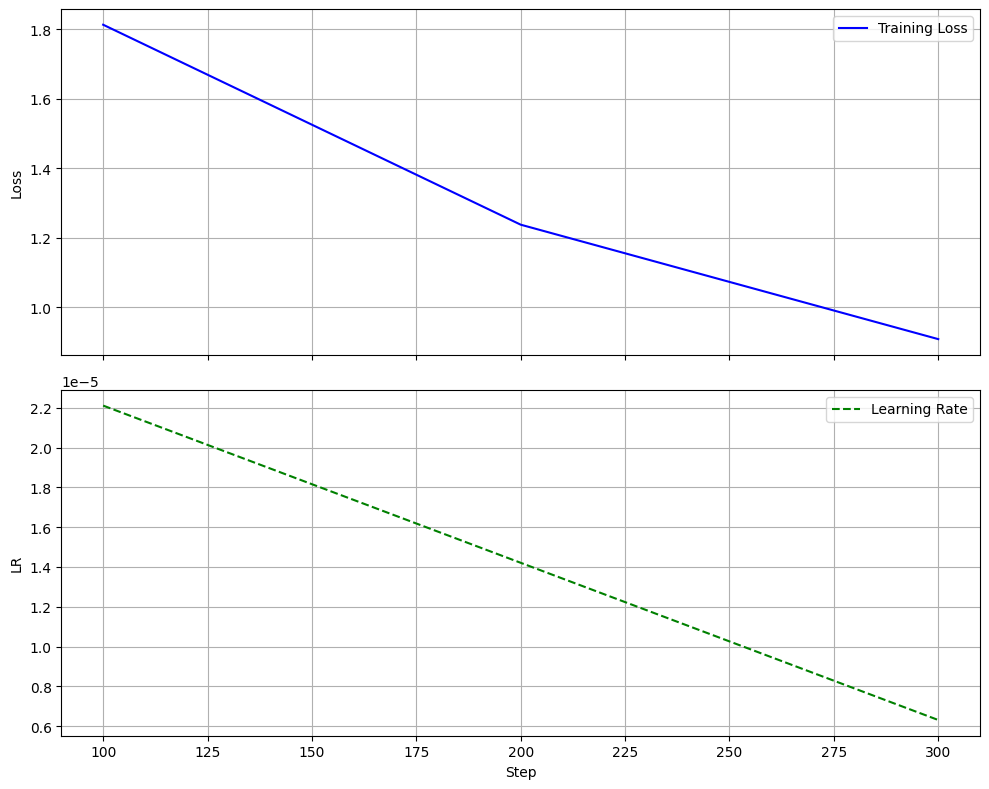

In [58]:
with open(trainer_state_path_3, "r") as f:
    state_2 = json.load(f)

# Pass only the log history to the plotting function
plot_training_logs(state_2["log_history"])


#### Confusion matrix

##### 1.

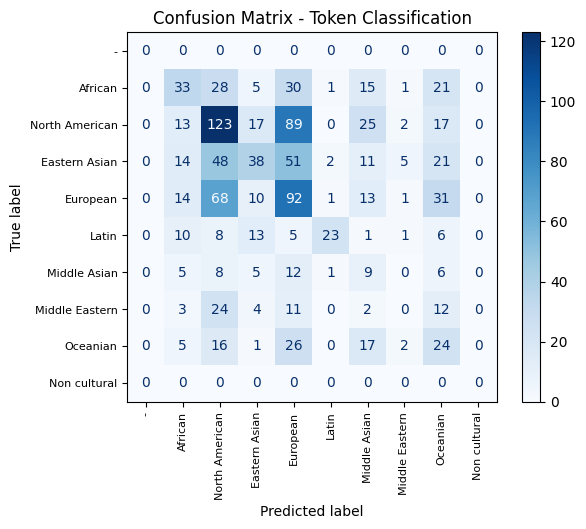

In [ ]:
# filtered = [(p, l) for pred, label in zip(preds_2, labels_2) for p, l in zip(pred, label) if l != -100]
# pred_labels, true_labels = zip(*filtered)
# pred_labels = list(pred_labels)
# true_labels = list(true_labels)


# # Confusion Matrix Calculation
# cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(id2tag_cultural))))

# # Mapping labels
# all_labels = list(id2tag_cultural.values())

# # Plotting the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix - Token Classification")
# plt.xticks(fontsize=8, rotation=90)
# plt.yticks(fontsize=8)
# plt.show()

##### 2.

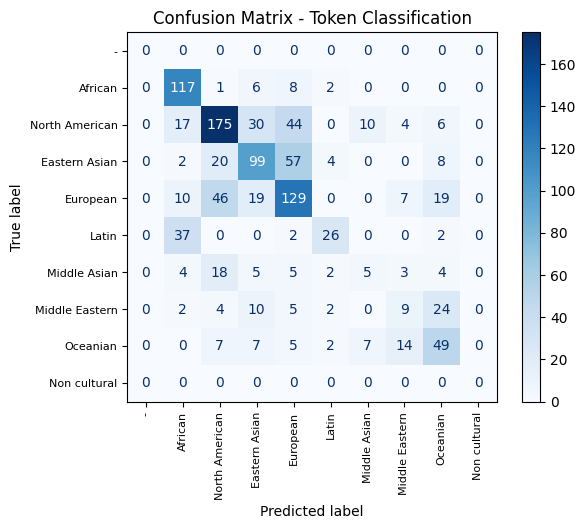

In [ ]:
# # Use list comprehension for better performance
# true_labels = [l for pred, label in zip(preds, labels) for p, l in zip(pred, label) if l != -100]
# pred_labels = [p for pred, label in zip(preds, labels) for p, l in zip(pred, label) if l != -100]

# # Confusion Matrix Calculation
# cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(id2tag_cultural))))

# # Mapping labels
# all_labels = list(id2tag_cultural.values())

# # Plotting the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix - Token Classification")
# plt.xticks(fontsize=8, rotation=90)
# plt.yticks(fontsize=8)
# plt.show()

##### 3. 

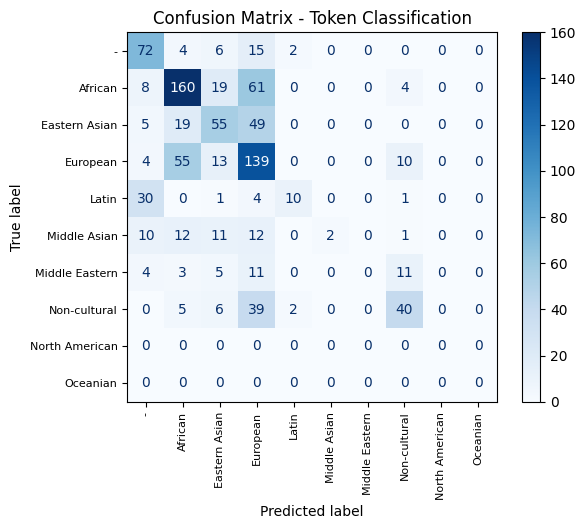

In [59]:
# Use list comprehension for better performance
true_labels = [l for pred, label in zip(preds_fun, labels_fun) for p, l in zip(pred, label) if l != -100]
pred_labels = [p for pred, label in zip(preds_fun, labels_fun) for p, l in zip(pred, label) if l != -100]

# Confusion Matrix Calculation
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(id2tag_cultural))))

# Mapping labels
all_labels = list(id2tag_cultural.values())

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Token Classification")
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)
plt.show()